# Hovmoller plots using BARRA-2

In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import warnings
import sys
import metpy
import matplotlib
import matplotlib.gridspec as gridspec
import geopandas
import metpy.calc as mpcalc
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import pandas as pd
from netCDF4 import Dataset
import os
import glob

In [2]:
warnings.filterwarnings('ignore')
%matplotlib inline

# Hovmoller function

In [3]:
# define function to plot
def plot_hovmoller(variable,suptitle,level_data,cmap,cbar_units,anomaly=None,temp=None):  
    # create time slices between 25th and 28th
    start_time = '2022-02-08T03:30:00.000000000'
    end_time = '2022-02-16T02:30:00.000000000'
    time_slice = slice(start_time, end_time)
    # lat T = -19.47
    lat_C = -16.830002 # -16.817
    lat_W = -16.279999 # -16.2874
    lon_slice_T = slice(144, 149)                  
    lon_slice_C = slice(143,148)
    lon_slice_W = slice(147,153)

    # Get data, selecting time, lat/lon slice
    if anomaly==True:
        variable_data_T = barra2_ds[variable].isel(latitude=361).sel(longitude=lon_slice_T,time=time_slice
                        ).groupby("time.day") - barra2_ds[variable].isel(latitude=361).sel(longitude=lon_slice_T,
                        time=time_slice).groupby("time.day").mean()

        variable_data_C = barra2_ds[variable].isel(latitude=385).sel(longitude=lon_slice_C,time=time_slice
                        ).groupby("time.day") - barra2_ds[variable].isel(latitude=385).sel(longitude=lon_slice_C,
                        time=time_slice).groupby("time.day").mean()

        variable_data_W = barra2_ds[variable].isel(latitude=390).sel(longitude=lon_slice_W,time=time_slice
                        ).groupby("time.day") - barra2_ds[variable].isel(latitude=390).sel(longitude=lon_slice_W,
                        time=time_slice).groupby("time.day").mean()
        
    else:
        if temp==True:
            variable_data_T = barra2_ds[variable].isel(latitude=361).sel(longitude=lon_slice_T,time=time_slice) - 273.15
            variable_data_C = barra2_ds[variable].isel(latitude=385).sel(longitude=lon_slice_C,time=time_slice) - 273.15
            variable_data_W = barra2_ds[variable].isel(latitude=390).sel(longitude=lon_slice_W,time=time_slice) - 273.15
        else:
            variable_data_T = barra2_ds[variable].isel(latitude=361).sel(longitude=lon_slice_T,time=time_slice,pressure=850) 
            variable_data_C = barra2_ds[variable].isel(latitude=385).sel(longitude=lon_slice_C,time=time_slice,pressure=850) 
            variable_data_W = barra2_ds[variable].isel(latitude=390).sel(longitude=lon_slice_W,time=time_slice,pressure=850) 

    # Get times and make array of datetime objects
    variable_times_T = variable_data_T.time.values.astype('datetime64[ns]').astype('O')
    variable_times_C = variable_data_C.time.values.astype('datetime64[ns]').astype('O')
    variable_times_W = variable_data_W.time.values.astype('datetime64[ns]').astype('O')

    # Specify longitude values for chosen domain
    lons_T = variable_data_T.longitude.values
    lons_C = variable_data_C.longitude.values
    lons_W = variable_data_W.longitude.values 
    
    # make plot
    fig, ax = plt.subplots(1,3,figsize=(18,10))
    fig.patch.set_facecolor('white')

    # Set some titles
    ax[0].set_title('Townsville', loc='left', fontsize=20,fontweight=0.9)
    ax[1].set_title('Cairns', loc='left', fontsize=20,fontweight=0.9)
    ax[2].set_title('Willis Island', loc='left', fontsize=20,fontweight=0.9)
    fig.figure.suptitle(suptitle,fontsize=30) #,x=0.2,y=0.98,

    # Plot of chosen variable averaged over latitude and slightly smoothed
    levels = level_data
    cf_T = ax[0].contourf(lons_T, variable_times_T, variable_data_T, levels=levels, cmap=cmap, extend='both')
    cf_C = ax[1].contourf(lons_C, variable_times_C, variable_data_C, levels=levels, cmap=cmap, extend='both')
    cf_W = ax[2].contourf(lons_W, variable_times_W, variable_data_W, levels=levels, cmap=cmap, extend='both')

    line_colors = ['black' for l in cf_T.levels]
    cs_T = ax[0].contour(lons_T, variable_times_T, variable_data_T, alpha=0.5,colors=line_colors, linewidths=0.8,linestyles='-')
    cs_C = ax[1].contour(lons_C, variable_times_C, variable_data_C, alpha=0.5,colors=line_colors, linewidths=0.8,linestyles='-')
    cs_W = ax[2].contour(lons_W, variable_times_W, variable_data_W, alpha=0.5,colors=line_colors, linewidths=0.8,linestyles='-')                 
                    
    # cbar and cbar label                
    cbar_W = plt.colorbar(cf_T, ax=ax[2],orientation='vertical', pad=0.04, aspect=30, extendrect=True)
    cbar_W.set_label(cbar_units,fontsize=15)
    
    # plot vertical lines to represent coastlines
    ax[0].axvline(147.5,color='blue',alpha=0.2,linestyle='--')
    ax[1].axvline(145.75,color='blue',alpha=0.2,linestyle='--')
    
    # plot locations of radars
    ax[0].axvline(146.5509,color='k',alpha=0.5,linestyle='-.')
    ax[1].axvline(145.683,color='k',alpha=0.5,linestyle='-.')
    ax[2].axvline(149.9646,color='k',alpha=0.5,linestyle='-.')
    
    # Make some ticks and tick labels
    xticks_T = np.arange(144,150,1)
    xticks_C = np.arange(143,149,1)
    xticks_W = np.arange(147,154,1)            
    ax[0].set_xticks(xticks_T)
    ax[1].set_xticks(xticks_C)
    ax[2].set_xticks(xticks_W)
                    
    x_tick_labels_T = ["144","145","146","147","148","149"]
    x_tick_labels_C = ["143","144","145","146","147","148"]
    x_tick_labels_W = ["147","148","149","150","151","152","153"]        
    ax[0].set_xticklabels(x_tick_labels_T)
    ax[1].set_xticklabels(x_tick_labels_C)
    ax[2].set_xticklabels(x_tick_labels_W)
    
    y_tick_labels_T = ["8","9","10","11","12","13","14","15"]
    ax[0].set_yticklabels(y_tick_labels_T)
    ax[1].set(yticklabels=[]) 
    ax[2].set(yticklabels=[]) 
                    
    ax[0].set_xlabel("Longitude",fontsize=15)
    ax[1].set_xlabel("Longitude",fontsize=15)
    ax[2].set_xlabel("Longitude",fontsize=15)
    ax[0].set_ylabel("Day",fontsize=20)            
                    
    fig.tight_layout()
    plt.show()
    return

# Files to read

In [4]:
files_av_temp_scrn = [
    "/g/data/v46/yvh565/barra2/yhuang/20220208T0000Z/av_temp_scrn-barra_r2-hres-202202080300-202202080900.nc",
    "/g/data/v46/yvh565/barra2/yhuang/20220208T0600Z/av_temp_scrn-barra_r2-hres-202202080900-202202081500.nc",
    "/g/data/v46/yvh565/barra2/yhuang/20220208T1200Z/av_temp_scrn-barra_r2-hres-202202081500-202202082100.nc",
    "/g/data/v46/yvh565/barra2/yhuang/20220208T1800Z/av_temp_scrn-barra_r2-hres-202202082100-202202090300.nc",
    "/g/data/v46/yvh565/barra2/yhuang/20220209T0000Z/av_temp_scrn-barra_r2-hres-202202090300-202202090900.nc",
    "/g/data/v46/yvh565/barra2/yhuang/20220209T0600Z/av_temp_scrn-barra_r2-hres-202202090900-202202091500.nc",
    "/g/data/v46/yvh565/barra2/yhuang/20220209T1200Z/av_temp_scrn-barra_r2-hres-202202091500-202202092100.nc",
    "/g/data/v46/yvh565/barra2/yhuang/20220209T1800Z/av_temp_scrn-barra_r2-hres-202202092100-202202100300.nc",
    "/g/data/v46/yvh565/barra2/yhuang/20220210T0000Z/av_temp_scrn-barra_r2-hres-202202100300-202202100900.nc",
    "/g/data/v46/yvh565/barra2/yhuang/20220210T0600Z/av_temp_scrn-barra_r2-hres-202202100900-202202101500.nc",
    "/g/data/v46/yvh565/barra2/yhuang/20220210T1200Z/av_temp_scrn-barra_r2-hres-202202101500-202202102100.nc",
    "/g/data/v46/yvh565/barra2/yhuang/20220210T1800Z/av_temp_scrn-barra_r2-hres-202202102100-202202110300.nc",
    "/g/data/v46/yvh565/barra2/yhuang/20220211T0000Z/av_temp_scrn-barra_r2-hres-202202110300-202202110900.nc",
    "/g/data/v46/yvh565/barra2/yhuang/20220211T0600Z/av_temp_scrn-barra_r2-hres-202202110900-202202111500.nc",
    "/g/data/v46/yvh565/barra2/yhuang/20220211T1200Z/av_temp_scrn-barra_r2-hres-202202111500-202202112100.nc",
    "/g/data/v46/yvh565/barra2/yhuang/20220211T1800Z/av_temp_scrn-barra_r2-hres-202202112100-202202120300.nc",
    "/g/data/v46/yvh565/barra2/yhuang/20220212T0000Z/av_temp_scrn-barra_r2-hres-202202120300-202202120900.nc",
    "/g/data/v46/yvh565/barra2/yhuang/20220212T0600Z/av_temp_scrn-barra_r2-hres-202202120900-202202121500.nc",
    "/g/data/v46/yvh565/barra2/yhuang/20220212T1200Z/av_temp_scrn-barra_r2-hres-202202121500-202202122100.nc",
    "/g/data/v46/yvh565/barra2/yhuang/20220212T1800Z/av_temp_scrn-barra_r2-hres-202202122100-202202130300.nc",
    "/g/data/v46/yvh565/barra2/yhuang/20220213T0000Z/av_temp_scrn-barra_r2-hres-202202130300-202202130900.nc",
    "/g/data/v46/yvh565/barra2/yhuang/20220213T0600Z/av_temp_scrn-barra_r2-hres-202202130900-202202131500.nc",
    "/g/data/v46/yvh565/barra2/yhuang/20220213T1200Z/av_temp_scrn-barra_r2-hres-202202131500-202202132100.nc",
    "/g/data/v46/yvh565/barra2/yhuang/20220213T1800Z/av_temp_scrn-barra_r2-hres-202202132100-202202140300.nc",
    "/g/data/v46/yvh565/barra2/yhuang/20220214T0000Z/av_temp_scrn-barra_r2-hres-202202140300-202202140900.nc",
    "/g/data/v46/yvh565/barra2/yhuang/20220214T0600Z/av_temp_scrn-barra_r2-hres-202202140900-202202141500.nc",
    "/g/data/v46/yvh565/barra2/yhuang/20220214T1200Z/av_temp_scrn-barra_r2-hres-202202141500-202202142100.nc",
    "/g/data/v46/yvh565/barra2/yhuang/20220214T1800Z/av_temp_scrn-barra_r2-hres-202202142100-202202150300.nc",
    "/g/data/v46/yvh565/barra2/yhuang/20220215T0000Z/av_temp_scrn-barra_r2-hres-202202150300-202202150900.nc",
    "/g/data/v46/yvh565/barra2/yhuang/20220215T0600Z/av_temp_scrn-barra_r2-hres-202202150900-202202151500.nc",
    "/g/data/v46/yvh565/barra2/yhuang/20220215T1200Z/av_temp_scrn-barra_r2-hres-202202151500-202202152100.nc",
    "/g/data/v46/yvh565/barra2/yhuang/20220215T1800Z/av_temp_scrn-barra_r2-hres-202202152100-202202160300.nc",
]

In [5]:
barra2_ds.isel(latitude=361)

NameError: name 'barra2_ds' is not defined

In [6]:
barra2_ds = xr.open_mfdataset(files_av_temp_scrn, engine="netcdf4")

# Plot

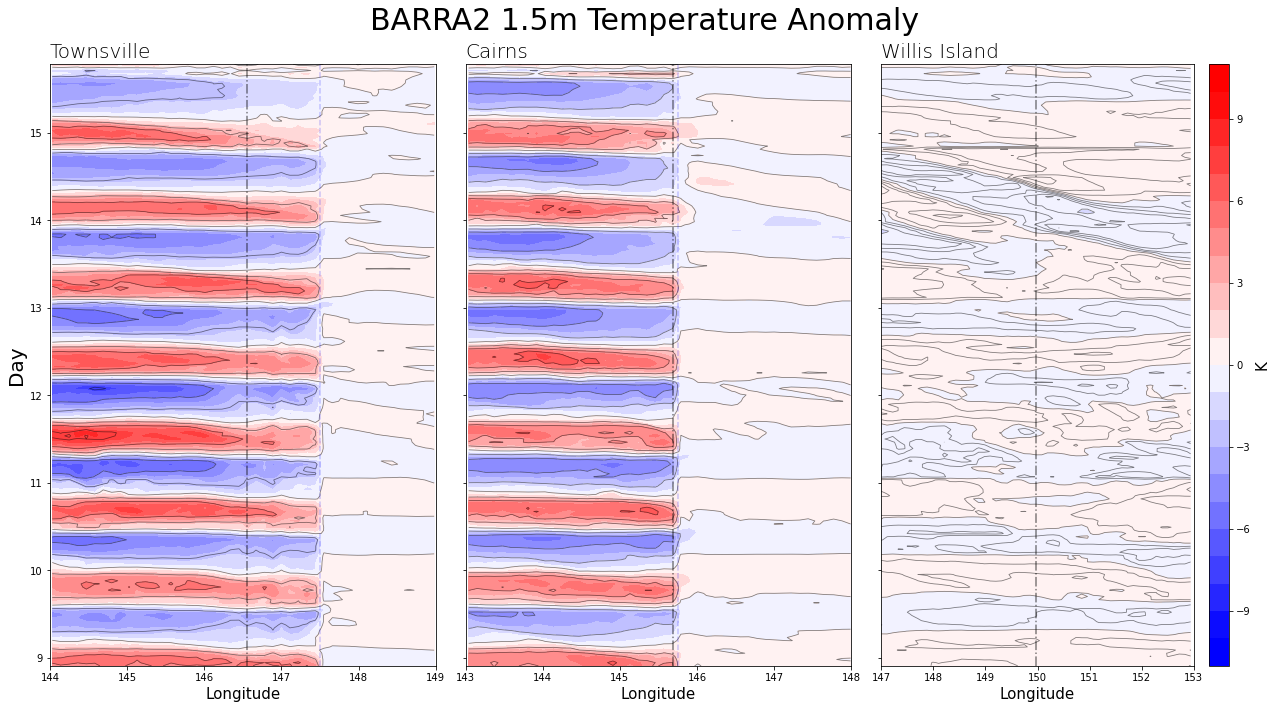

In [7]:
plot_hovmoller("av_temp_scrn","BARRA2 1.5m Temperature Anomaly",
               [-10,-9,-8,-7,-6,-5,-4,-3,-2,-1,0,1,2,3,4,5,6,7,8,9,10],"bwr","K",anomaly=True,temp=True)

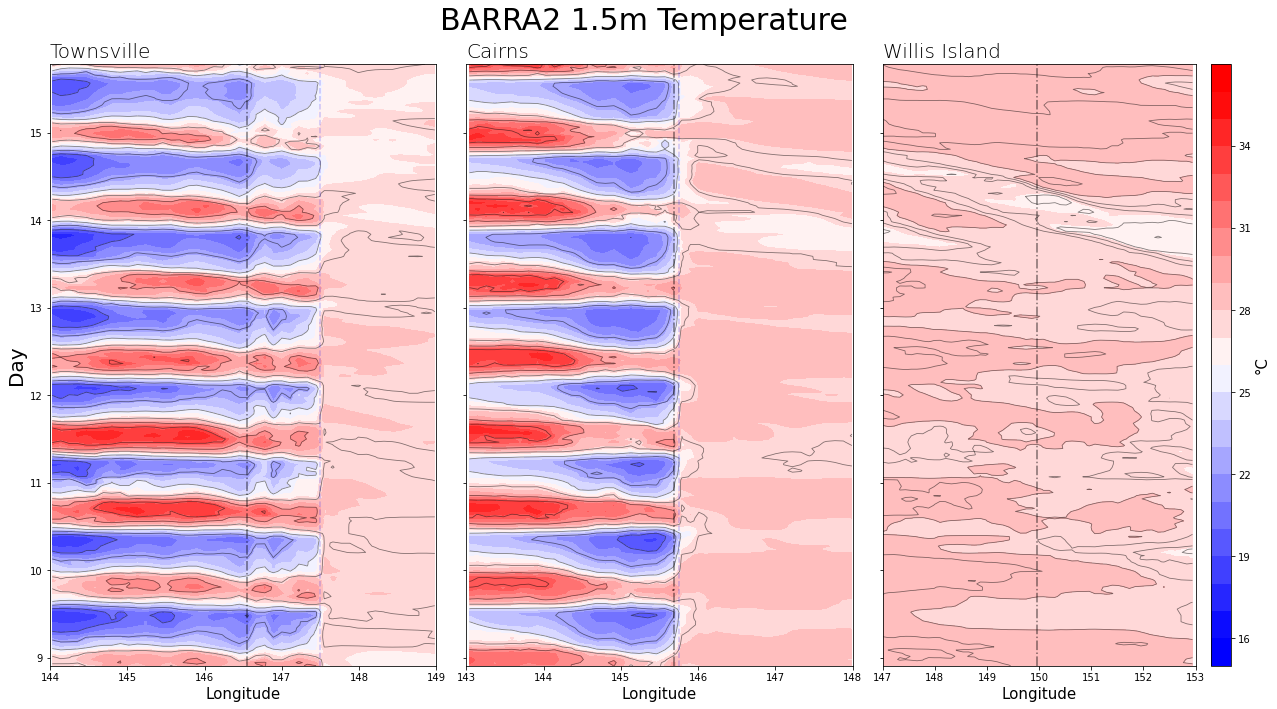

In [8]:
plot_hovmoller("av_temp_scrn","BARRA2 1.5m Temperature",
               [16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36],"bwr","°C",anomaly=False,temp=True)

# wind

In [9]:
files_av_uwnd10m_b = [
    "/g/data/v46/yvh565/barra2/yhuang/20220208T0000Z/av_uwnd10m_b-barra_r2-hres-202202080300-202202080900.nc",
    "/g/data/v46/yvh565/barra2/yhuang/20220208T0600Z/av_uwnd10m_b-barra_r2-hres-202202080900-202202081500.nc",
    "/g/data/v46/yvh565/barra2/yhuang/20220208T1200Z/av_uwnd10m_b-barra_r2-hres-202202081500-202202082100.nc",
    "/g/data/v46/yvh565/barra2/yhuang/20220208T1800Z/av_uwnd10m_b-barra_r2-hres-202202082100-202202090300.nc",
    "/g/data/v46/yvh565/barra2/yhuang/20220209T0000Z/av_uwnd10m_b-barra_r2-hres-202202090300-202202090900.nc",
    "/g/data/v46/yvh565/barra2/yhuang/20220209T0600Z/av_uwnd10m_b-barra_r2-hres-202202090900-202202091500.nc",
    "/g/data/v46/yvh565/barra2/yhuang/20220209T1200Z/av_uwnd10m_b-barra_r2-hres-202202091500-202202092100.nc",
    "/g/data/v46/yvh565/barra2/yhuang/20220209T1800Z/av_uwnd10m_b-barra_r2-hres-202202092100-202202100300.nc",
    "/g/data/v46/yvh565/barra2/yhuang/20220210T0000Z/av_uwnd10m_b-barra_r2-hres-202202100300-202202100900.nc",
    "/g/data/v46/yvh565/barra2/yhuang/20220210T0600Z/av_uwnd10m_b-barra_r2-hres-202202100900-202202101500.nc",
    "/g/data/v46/yvh565/barra2/yhuang/20220210T1200Z/av_uwnd10m_b-barra_r2-hres-202202101500-202202102100.nc",
    "/g/data/v46/yvh565/barra2/yhuang/20220210T1800Z/av_uwnd10m_b-barra_r2-hres-202202102100-202202110300.nc",
    "/g/data/v46/yvh565/barra2/yhuang/20220211T0000Z/av_uwnd10m_b-barra_r2-hres-202202110300-202202110900.nc",
    "/g/data/v46/yvh565/barra2/yhuang/20220211T0600Z/av_uwnd10m_b-barra_r2-hres-202202110900-202202111500.nc",
    "/g/data/v46/yvh565/barra2/yhuang/20220211T1200Z/av_uwnd10m_b-barra_r2-hres-202202111500-202202112100.nc",
    "/g/data/v46/yvh565/barra2/yhuang/20220211T1800Z/av_uwnd10m_b-barra_r2-hres-202202112100-202202120300.nc",
    "/g/data/v46/yvh565/barra2/yhuang/20220212T0000Z/av_uwnd10m_b-barra_r2-hres-202202120300-202202120900.nc",
    "/g/data/v46/yvh565/barra2/yhuang/20220212T0600Z/av_uwnd10m_b-barra_r2-hres-202202120900-202202121500.nc",
    "/g/data/v46/yvh565/barra2/yhuang/20220212T1200Z/av_uwnd10m_b-barra_r2-hres-202202121500-202202122100.nc",
    "/g/data/v46/yvh565/barra2/yhuang/20220212T1800Z/av_uwnd10m_b-barra_r2-hres-202202122100-202202130300.nc",
    "/g/data/v46/yvh565/barra2/yhuang/20220213T0000Z/av_uwnd10m_b-barra_r2-hres-202202130300-202202130900.nc",
    "/g/data/v46/yvh565/barra2/yhuang/20220213T0600Z/av_uwnd10m_b-barra_r2-hres-202202130900-202202131500.nc",
    "/g/data/v46/yvh565/barra2/yhuang/20220213T1200Z/av_uwnd10m_b-barra_r2-hres-202202131500-202202132100.nc",
    "/g/data/v46/yvh565/barra2/yhuang/20220213T1800Z/av_uwnd10m_b-barra_r2-hres-202202132100-202202140300.nc",
    "/g/data/v46/yvh565/barra2/yhuang/20220214T0000Z/av_uwnd10m_b-barra_r2-hres-202202140300-202202140900.nc",
    "/g/data/v46/yvh565/barra2/yhuang/20220214T0600Z/av_uwnd10m_b-barra_r2-hres-202202140900-202202141500.nc",
    "/g/data/v46/yvh565/barra2/yhuang/20220214T1200Z/av_uwnd10m_b-barra_r2-hres-202202141500-202202142100.nc",
    "/g/data/v46/yvh565/barra2/yhuang/20220214T1800Z/av_uwnd10m_b-barra_r2-hres-202202142100-202202150300.nc",
    "/g/data/v46/yvh565/barra2/yhuang/20220215T0000Z/av_uwnd10m_b-barra_r2-hres-202202150300-202202150900.nc",
    "/g/data/v46/yvh565/barra2/yhuang/20220215T0600Z/av_uwnd10m_b-barra_r2-hres-202202150900-202202151500.nc",
    "/g/data/v46/yvh565/barra2/yhuang/20220215T1200Z/av_uwnd10m_b-barra_r2-hres-202202151500-202202152100.nc",
    "/g/data/v46/yvh565/barra2/yhuang/20220215T1800Z/av_uwnd10m_b-barra_r2-hres-202202152100-202202160300.nc",
]

In [10]:
barra2_ds = xr.open_mfdataset(files_av_uwnd10m_b, engine="netcdf4")

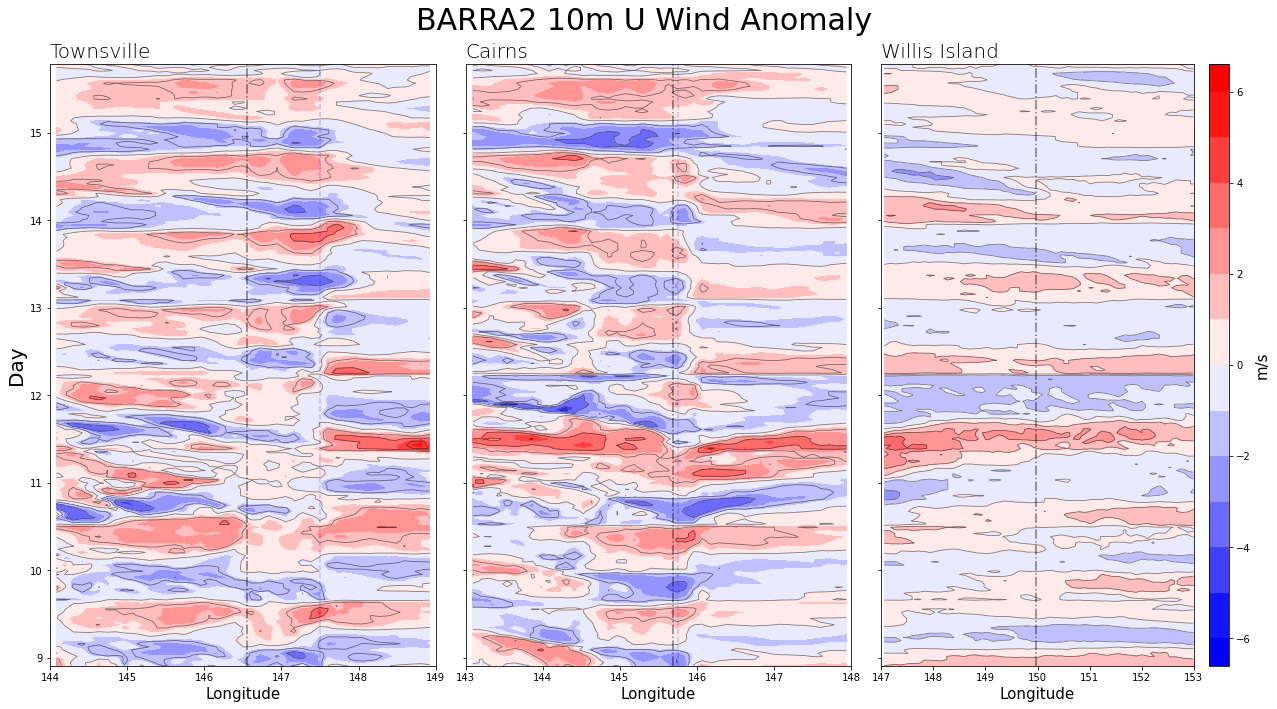

In [11]:
plot_hovmoller("av_uwnd10m_b","BARRA2 10m U Wind Anomaly",
               [-6,-5,-4,-3,-2,-1,0,1,2,3,4,5,6],"bwr","m/s",anomaly=True,temp=False)

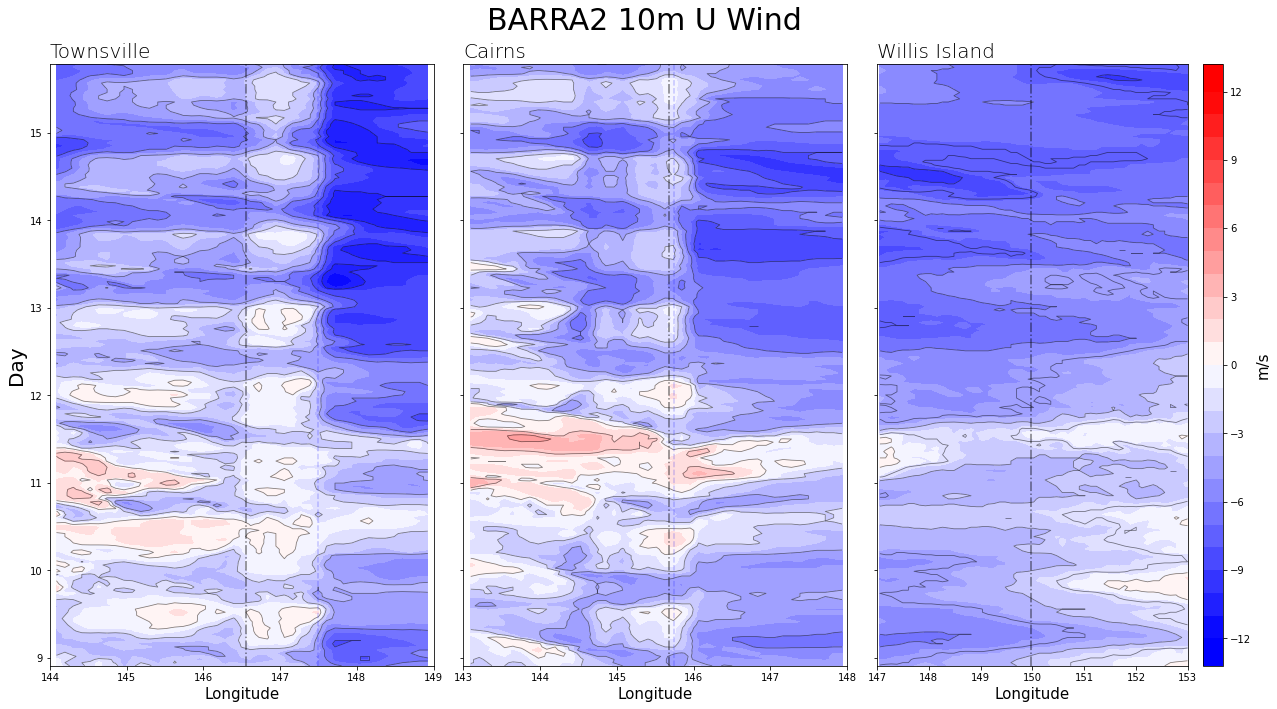

In [12]:
plot_hovmoller("av_uwnd10m_b","BARRA2 10m U Wind",
               [-12,-11,-10,-9,-8,-7,-6,-5,-4,-3,-2,-1,0,1,2,3,4,5,6,7,8,9,10,11,12],"bwr","m/s",anomaly=False,temp=False)

# U wind at other pressure levels

In [5]:
variable = "wnd_ucmp"
files_wnd_ucmp = [
    "/g/data/v46/yvh565/barra2/yhuang/20220208T0000Z/"+variable+"-barra_r2-hres-202202080300-202202080900.nc",
    "/g/data/v46/yvh565/barra2/yhuang/20220208T0600Z/"+variable+"-barra_r2-hres-202202080900-202202081500.nc",
    "/g/data/v46/yvh565/barra2/yhuang/20220208T1200Z/"+variable+"-barra_r2-hres-202202081500-202202082100.nc",
    "/g/data/v46/yvh565/barra2/yhuang/20220208T1800Z/"+variable+"-barra_r2-hres-202202082100-202202090300.nc",
    "/g/data/v46/yvh565/barra2/yhuang/20220209T0000Z/"+variable+"-barra_r2-hres-202202090300-202202090900.nc",
    "/g/data/v46/yvh565/barra2/yhuang/20220209T0600Z/"+variable+"-barra_r2-hres-202202090900-202202091500.nc",
    "/g/data/v46/yvh565/barra2/yhuang/20220209T1200Z/"+variable+"-barra_r2-hres-202202091500-202202092100.nc",
    "/g/data/v46/yvh565/barra2/yhuang/20220209T1800Z/"+variable+"-barra_r2-hres-202202092100-202202100300.nc",
    "/g/data/v46/yvh565/barra2/yhuang/20220210T0000Z/"+variable+"-barra_r2-hres-202202100300-202202100900.nc",
    "/g/data/v46/yvh565/barra2/yhuang/20220210T0600Z/"+variable+"-barra_r2-hres-202202100900-202202101500.nc",
    "/g/data/v46/yvh565/barra2/yhuang/20220210T1200Z/"+variable+"-barra_r2-hres-202202101500-202202102100.nc",
    "/g/data/v46/yvh565/barra2/yhuang/20220210T1800Z/"+variable+"-barra_r2-hres-202202102100-202202110300.nc",
    "/g/data/v46/yvh565/barra2/yhuang/20220211T0000Z/"+variable+"-barra_r2-hres-202202110300-202202110900.nc",
    "/g/data/v46/yvh565/barra2/yhuang/20220211T0600Z/"+variable+"-barra_r2-hres-202202110900-202202111500.nc",
    "/g/data/v46/yvh565/barra2/yhuang/20220211T1200Z/"+variable+"-barra_r2-hres-202202111500-202202112100.nc",
    "/g/data/v46/yvh565/barra2/yhuang/20220211T1800Z/"+variable+"-barra_r2-hres-202202112100-202202120300.nc",
    "/g/data/v46/yvh565/barra2/yhuang/20220212T0000Z/"+variable+"-barra_r2-hres-202202120300-202202120900.nc",
    "/g/data/v46/yvh565/barra2/yhuang/20220212T0600Z/"+variable+"-barra_r2-hres-202202120900-202202121500.nc",
    "/g/data/v46/yvh565/barra2/yhuang/20220212T1200Z/"+variable+"-barra_r2-hres-202202121500-202202122100.nc",
    "/g/data/v46/yvh565/barra2/yhuang/20220212T1800Z/"+variable+"-barra_r2-hres-202202122100-202202130300.nc",
    "/g/data/v46/yvh565/barra2/yhuang/20220213T0000Z/"+variable+"-barra_r2-hres-202202130300-202202130900.nc",
    "/g/data/v46/yvh565/barra2/yhuang/20220213T0600Z/"+variable+"-barra_r2-hres-202202130900-202202131500.nc",
    "/g/data/v46/yvh565/barra2/yhuang/20220213T1200Z/"+variable+"-barra_r2-hres-202202131500-202202132100.nc",
    "/g/data/v46/yvh565/barra2/yhuang/20220213T1800Z/"+variable+"-barra_r2-hres-202202132100-202202140300.nc",
    "/g/data/v46/yvh565/barra2/yhuang/20220214T0000Z/"+variable+"-barra_r2-hres-202202140300-202202140900.nc",
    "/g/data/v46/yvh565/barra2/yhuang/20220214T0600Z/"+variable+"-barra_r2-hres-202202140900-202202141500.nc",
    "/g/data/v46/yvh565/barra2/yhuang/20220214T1200Z/"+variable+"-barra_r2-hres-202202141500-202202142100.nc",
    "/g/data/v46/yvh565/barra2/yhuang/20220214T1800Z/"+variable+"-barra_r2-hres-202202142100-202202150300.nc",
    "/g/data/v46/yvh565/barra2/yhuang/20220215T0000Z/"+variable+"-barra_r2-hres-202202150300-202202150900.nc",
    "/g/data/v46/yvh565/barra2/yhuang/20220215T0600Z/"+variable+"-barra_r2-hres-202202150900-202202151500.nc",
    "/g/data/v46/yvh565/barra2/yhuang/20220215T1200Z/"+variable+"-barra_r2-hres-202202151500-202202152100.nc",
    "/g/data/v46/yvh565/barra2/yhuang/20220215T1800Z/"+variable+"-barra_r2-hres-202202152100-202202160300.nc",
]
barra2_ds = xr.open_mfdataset(files_wnd_ucmp, engine="netcdf4")

In [51]:
barra2_ds

<xarray.Dataset>
Dimensions:                  (time: 96, pressure: 8, latitude: 669,
                              longitude: 1104)
Coordinates:
  * time                     (time) datetime64[ns] 2022-02-08T03:00:00 ... 20...
  * pressure                 (pressure) float64 10.0 20.0 30.0 ... 150.0 250.0
  * latitude                 (latitude) float64 -59.24 -59.12 ... 14.14 14.25
  * longitude                (longitude) float64 87.21 87.32 ... 208.4 208.5
    forecast_reference_time  (time) datetime64[ns] 2022-02-08 ... 2022-02-15T...
    forecast_period          (time) timedelta64[ns] dask.array<chunksize=(3,), meta=np.ndarray>
Data variables:
    wnd_ucmp                 (time, pressure, latitude, longitude) float64 dask.array<chunksize=(3, 8, 669, 1104), meta=np.ndarray>
Attributes: (12/58)
    source:                         Data from Met Office Unified Model
    um_version:                     11.9
    geospatial_lat_min:             -59.235
    geospatial_lat_max:             14.245003
    geospatial_lat_resolution:      0.11000001
    geospatial_lat_resolution_min:  0.10999298
    ...                             ...
    packing_accuracy:               -8
    zlib:                           True
    compression_level:              4
    shuffle:                        True
    fletcher32:                     True
    chunksizes:                     [  3   2 232 373]

In [37]:
np.mean(barra2_ds["wnd_ucmp"].sel(pressure=250).values)

9.975716597141249

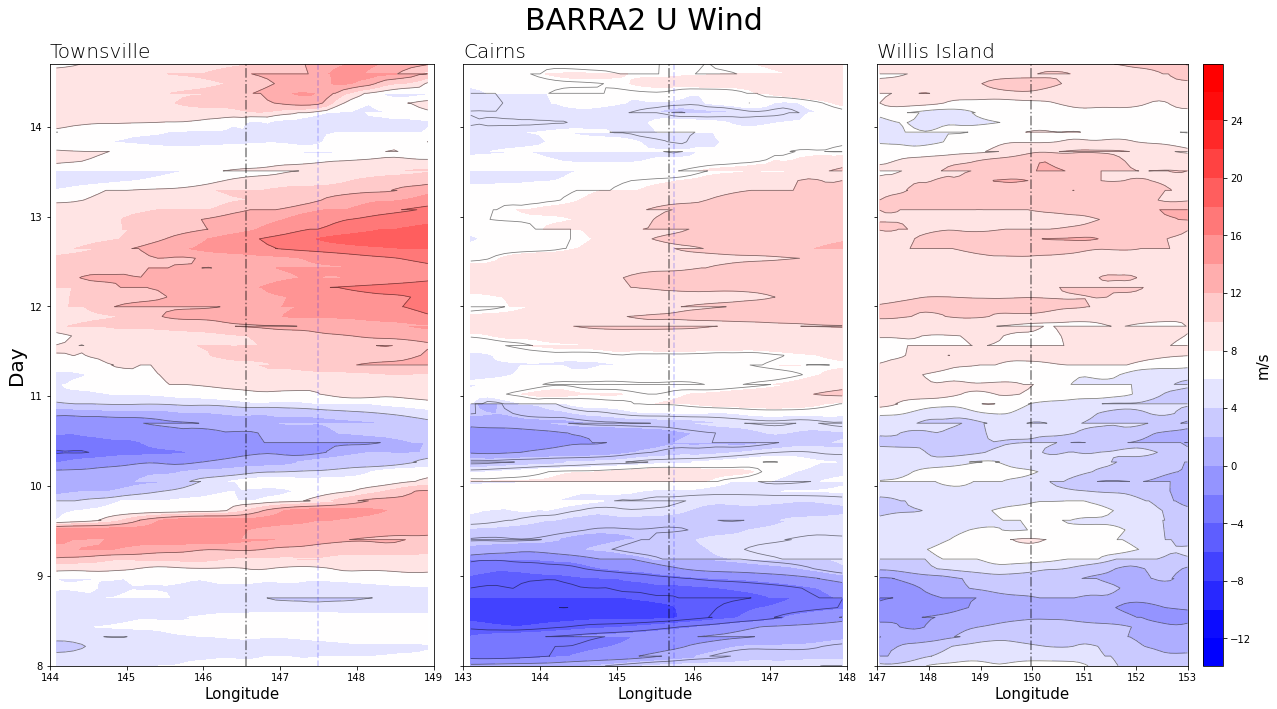

In [26]:
plot_hovmoller("wnd_ucmp","BARRA2 U Wind",
               [-12,-10,-8,-6,-4,-2,0,2,4,6,8,10,12,14,16,18,20,22,24,26],"bwr","m/s",anomaly=False,temp=False)

In [4]:
variable = "av_wnd_ucmp_uv"
files_av_wnd_ucmp_uv = [
    "/g/data/v46/yvh565/barra2/yhuang/20220208T0000Z/"+variable+"-barra_r2-hres-202202080300-202202080900.nc",
    "/g/data/v46/yvh565/barra2/yhuang/20220208T0600Z/"+variable+"-barra_r2-hres-202202080900-202202081500.nc",
    "/g/data/v46/yvh565/barra2/yhuang/20220208T1200Z/"+variable+"-barra_r2-hres-202202081500-202202082100.nc",
    "/g/data/v46/yvh565/barra2/yhuang/20220208T1800Z/"+variable+"-barra_r2-hres-202202082100-202202090300.nc",
    "/g/data/v46/yvh565/barra2/yhuang/20220209T0000Z/"+variable+"-barra_r2-hres-202202090300-202202090900.nc",
    "/g/data/v46/yvh565/barra2/yhuang/20220209T0600Z/"+variable+"-barra_r2-hres-202202090900-202202091500.nc",
    "/g/data/v46/yvh565/barra2/yhuang/20220209T1200Z/"+variable+"-barra_r2-hres-202202091500-202202092100.nc",
    "/g/data/v46/yvh565/barra2/yhuang/20220209T1800Z/"+variable+"-barra_r2-hres-202202092100-202202100300.nc",
    "/g/data/v46/yvh565/barra2/yhuang/20220210T0000Z/"+variable+"-barra_r2-hres-202202100300-202202100900.nc",
    "/g/data/v46/yvh565/barra2/yhuang/20220210T0600Z/"+variable+"-barra_r2-hres-202202100900-202202101500.nc",
    "/g/data/v46/yvh565/barra2/yhuang/20220210T1200Z/"+variable+"-barra_r2-hres-202202101500-202202102100.nc",
    "/g/data/v46/yvh565/barra2/yhuang/20220210T1800Z/"+variable+"-barra_r2-hres-202202102100-202202110300.nc",
    "/g/data/v46/yvh565/barra2/yhuang/20220211T0000Z/"+variable+"-barra_r2-hres-202202110300-202202110900.nc",
    "/g/data/v46/yvh565/barra2/yhuang/20220211T0600Z/"+variable+"-barra_r2-hres-202202110900-202202111500.nc",
    "/g/data/v46/yvh565/barra2/yhuang/20220211T1200Z/"+variable+"-barra_r2-hres-202202111500-202202112100.nc",
    "/g/data/v46/yvh565/barra2/yhuang/20220211T1800Z/"+variable+"-barra_r2-hres-202202112100-202202120300.nc",
    "/g/data/v46/yvh565/barra2/yhuang/20220212T0000Z/"+variable+"-barra_r2-hres-202202120300-202202120900.nc",
    "/g/data/v46/yvh565/barra2/yhuang/20220212T0600Z/"+variable+"-barra_r2-hres-202202120900-202202121500.nc",
    "/g/data/v46/yvh565/barra2/yhuang/20220212T1200Z/"+variable+"-barra_r2-hres-202202121500-202202122100.nc",
    "/g/data/v46/yvh565/barra2/yhuang/20220212T1800Z/"+variable+"-barra_r2-hres-202202122100-202202130300.nc",
    "/g/data/v46/yvh565/barra2/yhuang/20220213T0000Z/"+variable+"-barra_r2-hres-202202130300-202202130900.nc",
    "/g/data/v46/yvh565/barra2/yhuang/20220213T0600Z/"+variable+"-barra_r2-hres-202202130900-202202131500.nc",
    "/g/data/v46/yvh565/barra2/yhuang/20220213T1200Z/"+variable+"-barra_r2-hres-202202131500-202202132100.nc",
    "/g/data/v46/yvh565/barra2/yhuang/20220213T1800Z/"+variable+"-barra_r2-hres-202202132100-202202140300.nc",
    "/g/data/v46/yvh565/barra2/yhuang/20220214T0000Z/"+variable+"-barra_r2-hres-202202140300-202202140900.nc",
    "/g/data/v46/yvh565/barra2/yhuang/20220214T0600Z/"+variable+"-barra_r2-hres-202202140900-202202141500.nc",
    "/g/data/v46/yvh565/barra2/yhuang/20220214T1200Z/"+variable+"-barra_r2-hres-202202141500-202202142100.nc",
    "/g/data/v46/yvh565/barra2/yhuang/20220214T1800Z/"+variable+"-barra_r2-hres-202202142100-202202150300.nc",
    "/g/data/v46/yvh565/barra2/yhuang/20220215T0000Z/"+variable+"-barra_r2-hres-202202150300-202202150900.nc",
    "/g/data/v46/yvh565/barra2/yhuang/20220215T0600Z/"+variable+"-barra_r2-hres-202202150900-202202151500.nc",
    "/g/data/v46/yvh565/barra2/yhuang/20220215T1200Z/"+variable+"-barra_r2-hres-202202151500-202202152100.nc",
    "/g/data/v46/yvh565/barra2/yhuang/20220215T1800Z/"+variable+"-barra_r2-hres-202202152100-202202160300.nc",
]
barra2_ds = xr.open_mfdataset(files_av_wnd_ucmp_uv, engine="netcdf4")

In [5]:
barra2_ds["av_wnd_ucmp_uv"]

<xarray.DataArray 'time' (time: 64)>
array(['2022-02-08T04:30:00.000000000', '2022-02-08T07:30:00.000000000',
       '2022-02-08T10:30:00.000000000', '2022-02-08T13:30:00.000000000',
       '2022-02-08T16:30:00.000000000', '2022-02-08T19:30:00.000000000',
       '2022-02-08T22:30:00.000000000', '2022-02-09T01:30:00.000000000',
       '2022-02-09T04:30:00.000000000', '2022-02-09T07:30:00.000000000',
       '2022-02-09T10:30:00.000000000', '2022-02-09T13:30:00.000000000',
       '2022-02-09T16:30:00.000000000', '2022-02-09T19:30:00.000000000',
       '2022-02-09T22:30:00.000000000', '2022-02-10T01:30:00.000000000',
       '2022-02-10T04:30:00.000000000', '2022-02-10T07:30:00.000000000',
       '2022-02-10T10:30:00.000000000', '2022-02-10T13:30:00.000000000',
       '2022-02-10T16:30:00.000000000', '2022-02-10T19:30:00.000000000',
       '2022-02-10T22:30:00.000000000', '2022-02-11T01:30:00.000000000',
       '2022-02-11T04:30:00.000000000', '2022-02-11T07:30:00.000000000',
       '2022-02-11T10:30:00.000000000', '2022-02-11T13:30:00.000000000',
       '2022-02-11T16:30:00.000000000', '2022-02-11T19:30:00.000000000',
       '2022-02-11T22:30:00.000000000', '2022-02-12T01:30:00.000000000',
       '2022-02-12T04:30:00.000000000', '2022-02-12T07:30:00.000000000',
       '2022-02-12T10:30:00.000000000', '2022-02-12T13:30:00.000000000',
       '2022-02-12T16:30:00.000000000', '2022-02-12T19:30:00.000000000',
       '2022-02-12T22:30:00.000000000', '2022-02-13T01:30:00.000000000',
       '2022-02-13T04:30:00.000000000', '2022-02-13T07:30:00.000000000',
       '2022-02-13T10:30:00.000000000', '2022-02-13T13:30:00.000000000',
       '2022-02-13T16:30:00.000000000', '2022-02-13T19:30:00.000000000',
       '2022-02-13T22:30:00.000000000', '2022-02-14T01:30:00.000000000',
       '2022-02-14T04:30:00.000000000', '2022-02-14T07:30:00.000000000',
       '2022-02-14T10:30:00.000000000', '2022-02-14T13:30:00.000000000',
       '2022-02-14T16:30:00.000000000', '2022-02-14T19:30:00.000000000',
       '2022-02-14T22:30:00.000000000', '2022-02-15T01:30:00.000000000',
       '2022-02-15T04:30:00.000000000', '2022-02-15T07:30:00.000000000',
       '2022-02-15T10:30:00.000000000', '2022-02-15T13:30:00.000000000',
       '2022-02-15T16:30:00.000000000', '2022-02-15T19:30:00.000000000',
       '2022-02-15T22:30:00.000000000', '2022-02-16T01:30:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time                     (time) datetime64[ns] 2022-02-08T04:30:00 ... 20...
    forecast_reference_time  (time) datetime64[ns] 2022-02-08 ... 2022-02-15T...
    forecast_period          (time) timedelta64[ns] dask.array<chunksize=(2,), meta=np.ndarray>
Attributes:
    standard_name:  time
    axis:           T
    long_name:      time
    bounds:         time_bnds

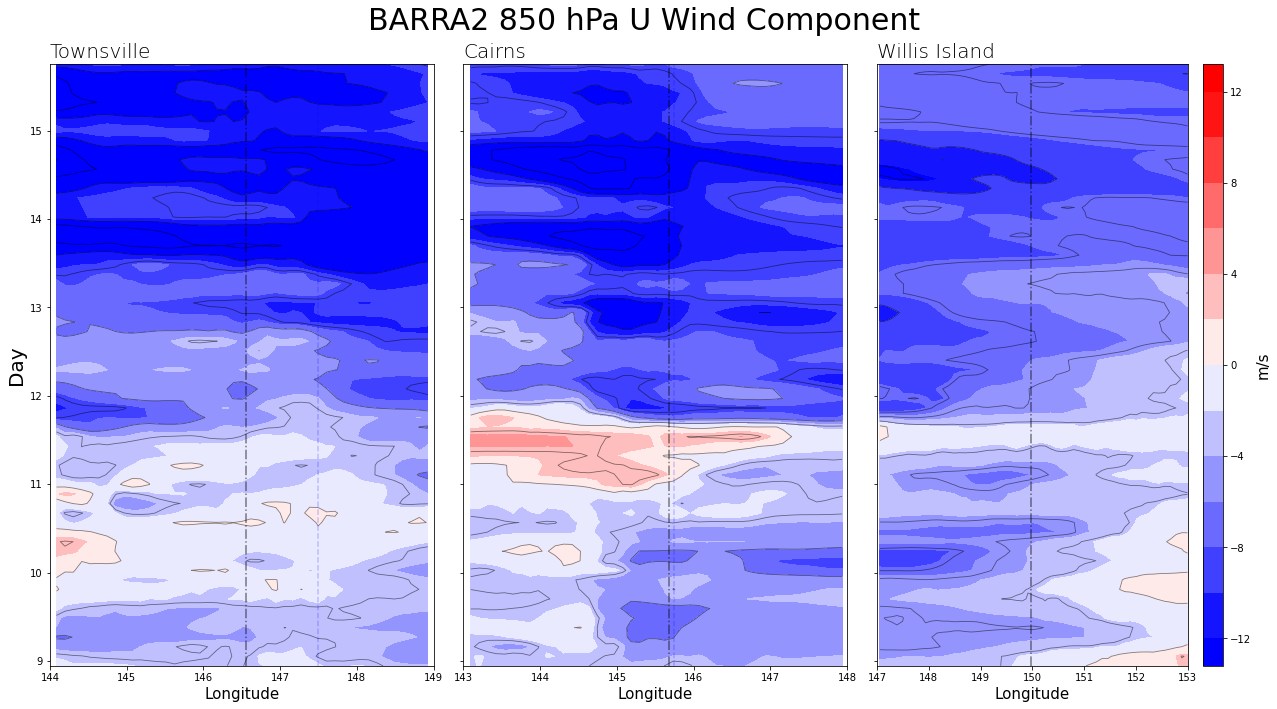

In [49]:
plot_hovmoller("av_wnd_ucmp_uv","BARRA2 850 hPa U Wind Component",
               [-12,-10,-8,-6,-4,-2,0,2,4,6,8,10,12],"bwr","m/s",anomaly=False,temp=False)

# no function

In [13]:
# read in barra2 data
indir = '/g/data/v46/yvh565/barra2/yhuang/20220208T0000Z/'
print('indir: ',indir)
file = indir+'av_sfc_temp-barra_r2-hres-202202080300-202202080900.nc' # path to file
print('file: ',file)
nc = Dataset(file, mode='r')                      # read the data 
print(type(nc))                                   # print the type of the data 
print(nc.variables.keys())                        # print variable keys

indir:  /g/data/v46/yvh565/barra2/yhuang/20220208T0000Z/
file:  /g/data/v46/yvh565/barra2/yhuang/20220208T0000Z/av_sfc_temp-barra_r2-hres-202202080300-202202080900.nc
<class 'netCDF4._netCDF4.Dataset'>
dict_keys(['time', 'latitude', 'longitude', 'forecast_reference_time', 'forecast_period', 'av_sfc_temp', 'bnds', 'time_bnds'])


In [14]:
files_av_sfc_temp = [
    "/g/data/v46/yvh565/barra2/yhuang/20220208T0000Z/av_sfc_temp-barra_r2-hres-202202080300-202202080900.nc",
    "/g/data/v46/yvh565/barra2/yhuang/20220208T0600Z/av_sfc_temp-barra_r2-hres-202202080900-202202081500.nc",
    "/g/data/v46/yvh565/barra2/yhuang/20220208T1200Z/av_sfc_temp-barra_r2-hres-202202081500-202202082100.nc",
    "/g/data/v46/yvh565/barra2/yhuang/20220208T1800Z/av_sfc_temp-barra_r2-hres-202202082100-202202090300.nc",
    "/g/data/v46/yvh565/barra2/yhuang/20220209T0000Z/av_sfc_temp-barra_r2-hres-202202090300-202202090900.nc",
    "/g/data/v46/yvh565/barra2/yhuang/20220209T0600Z/av_sfc_temp-barra_r2-hres-202202090900-202202091500.nc",
    "/g/data/v46/yvh565/barra2/yhuang/20220209T1200Z/av_sfc_temp-barra_r2-hres-202202091500-202202092100.nc",
    "/g/data/v46/yvh565/barra2/yhuang/20220209T1800Z/av_sfc_temp-barra_r2-hres-202202092100-202202100300.nc",
    "/g/data/v46/yvh565/barra2/yhuang/20220210T0000Z/av_sfc_temp-barra_r2-hres-202202100300-202202100900.nc",
    "/g/data/v46/yvh565/barra2/yhuang/20220210T0600Z/av_sfc_temp-barra_r2-hres-202202100900-202202101500.nc",
    "/g/data/v46/yvh565/barra2/yhuang/20220210T1200Z/av_sfc_temp-barra_r2-hres-202202101500-202202102100.nc",
    "/g/data/v46/yvh565/barra2/yhuang/20220210T1800Z/av_sfc_temp-barra_r2-hres-202202102100-202202110300.nc",
    "/g/data/v46/yvh565/barra2/yhuang/20220211T0000Z/av_sfc_temp-barra_r2-hres-202202110300-202202110900.nc",
    "/g/data/v46/yvh565/barra2/yhuang/20220211T0600Z/av_sfc_temp-barra_r2-hres-202202110900-202202111500.nc",
    "/g/data/v46/yvh565/barra2/yhuang/20220211T1200Z/av_sfc_temp-barra_r2-hres-202202111500-202202112100.nc",
    "/g/data/v46/yvh565/barra2/yhuang/20220211T1800Z/av_sfc_temp-barra_r2-hres-202202112100-202202120300.nc",
    "/g/data/v46/yvh565/barra2/yhuang/20220212T0000Z/av_sfc_temp-barra_r2-hres-202202120300-202202120900.nc",
    "/g/data/v46/yvh565/barra2/yhuang/20220212T0600Z/av_sfc_temp-barra_r2-hres-202202120900-202202121500.nc",
    "/g/data/v46/yvh565/barra2/yhuang/20220212T1200Z/av_sfc_temp-barra_r2-hres-202202121500-202202122100.nc",
    "/g/data/v46/yvh565/barra2/yhuang/20220212T1800Z/av_sfc_temp-barra_r2-hres-202202122100-202202130300.nc",
    "/g/data/v46/yvh565/barra2/yhuang/20220213T0000Z/av_sfc_temp-barra_r2-hres-202202130300-202202130900.nc",
    "/g/data/v46/yvh565/barra2/yhuang/20220213T0600Z/av_sfc_temp-barra_r2-hres-202202130900-202202131500.nc",
    "/g/data/v46/yvh565/barra2/yhuang/20220213T1200Z/av_sfc_temp-barra_r2-hres-202202131500-202202132100.nc",
    "/g/data/v46/yvh565/barra2/yhuang/20220213T1800Z/av_sfc_temp-barra_r2-hres-202202132100-202202140300.nc",
    "/g/data/v46/yvh565/barra2/yhuang/20220214T0000Z/av_sfc_temp-barra_r2-hres-202202140300-202202140900.nc",
    "/g/data/v46/yvh565/barra2/yhuang/20220214T0600Z/av_sfc_temp-barra_r2-hres-202202140900-202202141500.nc",
    "/g/data/v46/yvh565/barra2/yhuang/20220214T1200Z/av_sfc_temp-barra_r2-hres-202202141500-202202142100.nc",
    "/g/data/v46/yvh565/barra2/yhuang/20220214T1800Z/av_sfc_temp-barra_r2-hres-202202142100-202202150300.nc",
    "/g/data/v46/yvh565/barra2/yhuang/20220215T0000Z/av_sfc_temp-barra_r2-hres-202202150300-202202150900.nc",
    "/g/data/v46/yvh565/barra2/yhuang/20220215T0600Z/av_sfc_temp-barra_r2-hres-202202150900-202202151500.nc",
    "/g/data/v46/yvh565/barra2/yhuang/20220215T1200Z/av_sfc_temp-barra_r2-hres-202202151500-202202152100.nc",
    "/g/data/v46/yvh565/barra2/yhuang/20220215T1800Z/av_sfc_temp-barra_r2-hres-202202152100-202202160300.nc",
] # not much data over ocean

files_av_temp_scrn = [
    "/g/data/v46/yvh565/barra2/yhuang/20220208T0000Z/av_temp_scrn-barra_r2-hres-202202080300-202202080900.nc",
    "/g/data/v46/yvh565/barra2/yhuang/20220208T0600Z/av_temp_scrn-barra_r2-hres-202202080900-202202081500.nc",
    "/g/data/v46/yvh565/barra2/yhuang/20220208T1200Z/av_temp_scrn-barra_r2-hres-202202081500-202202082100.nc",
    "/g/data/v46/yvh565/barra2/yhuang/20220208T1800Z/av_temp_scrn-barra_r2-hres-202202082100-202202090300.nc",
    "/g/data/v46/yvh565/barra2/yhuang/20220209T0000Z/av_temp_scrn-barra_r2-hres-202202090300-202202090900.nc",
    "/g/data/v46/yvh565/barra2/yhuang/20220209T0600Z/av_temp_scrn-barra_r2-hres-202202090900-202202091500.nc",
    "/g/data/v46/yvh565/barra2/yhuang/20220209T1200Z/av_temp_scrn-barra_r2-hres-202202091500-202202092100.nc",
    "/g/data/v46/yvh565/barra2/yhuang/20220209T1800Z/av_temp_scrn-barra_r2-hres-202202092100-202202100300.nc",
    "/g/data/v46/yvh565/barra2/yhuang/20220210T0000Z/av_temp_scrn-barra_r2-hres-202202100300-202202100900.nc",
    "/g/data/v46/yvh565/barra2/yhuang/20220210T0600Z/av_temp_scrn-barra_r2-hres-202202100900-202202101500.nc",
    "/g/data/v46/yvh565/barra2/yhuang/20220210T1200Z/av_temp_scrn-barra_r2-hres-202202101500-202202102100.nc",
    "/g/data/v46/yvh565/barra2/yhuang/20220210T1800Z/av_temp_scrn-barra_r2-hres-202202102100-202202110300.nc",
    "/g/data/v46/yvh565/barra2/yhuang/20220211T0000Z/av_temp_scrn-barra_r2-hres-202202110300-202202110900.nc",
    "/g/data/v46/yvh565/barra2/yhuang/20220211T0600Z/av_temp_scrn-barra_r2-hres-202202110900-202202111500.nc",
    "/g/data/v46/yvh565/barra2/yhuang/20220211T1200Z/av_temp_scrn-barra_r2-hres-202202111500-202202112100.nc",
    "/g/data/v46/yvh565/barra2/yhuang/20220211T1800Z/av_temp_scrn-barra_r2-hres-202202112100-202202120300.nc",
    "/g/data/v46/yvh565/barra2/yhuang/20220212T0000Z/av_temp_scrn-barra_r2-hres-202202120300-202202120900.nc",
    "/g/data/v46/yvh565/barra2/yhuang/20220212T0600Z/av_temp_scrn-barra_r2-hres-202202120900-202202121500.nc",
    "/g/data/v46/yvh565/barra2/yhuang/20220212T1200Z/av_temp_scrn-barra_r2-hres-202202121500-202202122100.nc",
    "/g/data/v46/yvh565/barra2/yhuang/20220212T1800Z/av_temp_scrn-barra_r2-hres-202202122100-202202130300.nc",
    "/g/data/v46/yvh565/barra2/yhuang/20220213T0000Z/av_temp_scrn-barra_r2-hres-202202130300-202202130900.nc",
    "/g/data/v46/yvh565/barra2/yhuang/20220213T0600Z/av_temp_scrn-barra_r2-hres-202202130900-202202131500.nc",
    "/g/data/v46/yvh565/barra2/yhuang/20220213T1200Z/av_temp_scrn-barra_r2-hres-202202131500-202202132100.nc",
    "/g/data/v46/yvh565/barra2/yhuang/20220213T1800Z/av_temp_scrn-barra_r2-hres-202202132100-202202140300.nc",
    "/g/data/v46/yvh565/barra2/yhuang/20220214T0000Z/av_temp_scrn-barra_r2-hres-202202140300-202202140900.nc",
    "/g/data/v46/yvh565/barra2/yhuang/20220214T0600Z/av_temp_scrn-barra_r2-hres-202202140900-202202141500.nc",
    "/g/data/v46/yvh565/barra2/yhuang/20220214T1200Z/av_temp_scrn-barra_r2-hres-202202141500-202202142100.nc",
    "/g/data/v46/yvh565/barra2/yhuang/20220214T1800Z/av_temp_scrn-barra_r2-hres-202202142100-202202150300.nc",
    "/g/data/v46/yvh565/barra2/yhuang/20220215T0000Z/av_temp_scrn-barra_r2-hres-202202150300-202202150900.nc",
    "/g/data/v46/yvh565/barra2/yhuang/20220215T0600Z/av_temp_scrn-barra_r2-hres-202202150900-202202151500.nc",
    "/g/data/v46/yvh565/barra2/yhuang/20220215T1200Z/av_temp_scrn-barra_r2-hres-202202151500-202202152100.nc",
    "/g/data/v46/yvh565/barra2/yhuang/20220215T1800Z/av_temp_scrn-barra_r2-hres-202202152100-202202160300.nc",
]

In [15]:
barra2_ds = xr.open_mfdataset(files_av_temp_scrn, engine="netcdf4")
barra2_ds

<xarray.Dataset>
Dimensions:                  (time: 192, latitude: 668, longitude: 1104, bnds: 2)
Coordinates:
  * time                     (time) datetime64[ns] 2022-02-08T03:30:00 ... 20...
  * latitude                 (latitude) float64 -59.18 -59.07 ... 14.08 14.19
  * longitude                (longitude) float64 87.27 87.38 ... 208.5 208.6
    forecast_reference_time  (time) datetime64[ns] 2022-02-08 ... 2022-02-15T...
    height                   float64 1.5
    forecast_period          (time) timedelta64[ns] dask.array<chunksize=(6,), meta=np.ndarray>
  * bnds                     (bnds) float64 0.0 1.0
Data variables:
    av_temp_scrn             (time, latitude, longitude) float32 dask.array<chunksize=(6, 668, 1104), meta=np.ndarray>
    time_bnds                (time, bnds) datetime64[ns] dask.array<chunksize=(6, 2), meta=np.ndarray>
Attributes: (12/58)
    source:                         Data from Met Office Unified Model
    um_version:                     11.9
    geospatial_lat_min:             -59.18
    geospatial_lat_max:             14.190002
    geospatial_lat_resolution:      0.11000001
    geospatial_lat_resolution_min:  0.10999298
    ...                             ...
    packing_accuracy:               -6
    zlib:                           True
    compression_level:              4
    shuffle:                        True
    fletcher32:                     True
    chunksizes:                     [  6 213 341]

In [16]:
# create time slices between 25th and 28th
start_time = '2022-02-08T03:30:00.000000000'
end_time = '2022-02-16T02:30:00.000000000'
time_slice = slice(start_time, end_time)
lat_T = -19.470001  # -19.4198
lat_C = -16.830002 # -16.817
lat_W = -16.279999 # -16.2874
lon_slice_T = slice(144, 149)                  
lon_slice_C = slice(143,148)
lon_slice_W = slice(147,153)

# Get data, selecting time, lat/lon slice
variable_data_T = barra2_ds["av_temp_scrn"].isel(latitude=361).sel(longitude=lon_slice_T,time=time_slice
                        ).groupby("time.day") - barra2_ds["av_temp_scrn"].isel(latitude=361).sel(longitude=lon_slice_T,
                        time=time_slice).groupby("time.day").mean()

variable_data_C = barra2_ds["av_temp_scrn"].isel(latitude=385).sel(longitude=lon_slice_C,time=time_slice
                        ).groupby("time.day") - barra2_ds["av_temp_scrn"].isel(latitude=385).sel(longitude=lon_slice_C,
                        time=time_slice).groupby("time.day").mean()

variable_data_W = barra2_ds["av_temp_scrn"].isel(latitude=390).sel(longitude=lon_slice_W,time=time_slice
                        ).groupby("time.day") - barra2_ds["av_temp_scrn"].isel(latitude=390).sel(longitude=lon_slice_W,
                        time=time_slice).groupby("time.day").mean()

# Get times and make array of datetime objects
variable_times_T = variable_data_T.time.values.astype('datetime64[ns]').astype('O')
variable_times_C = variable_data_C.time.values.astype('datetime64[ns]').astype('O')
variable_times_W = variable_data_W.time.values.astype('datetime64[ns]').astype('O')

# Specify longitude values for chosen domain
lons_T = variable_data_T.longitude.values
lons_C = variable_data_C.longitude.values
lons_W = variable_data_W.longitude.values   

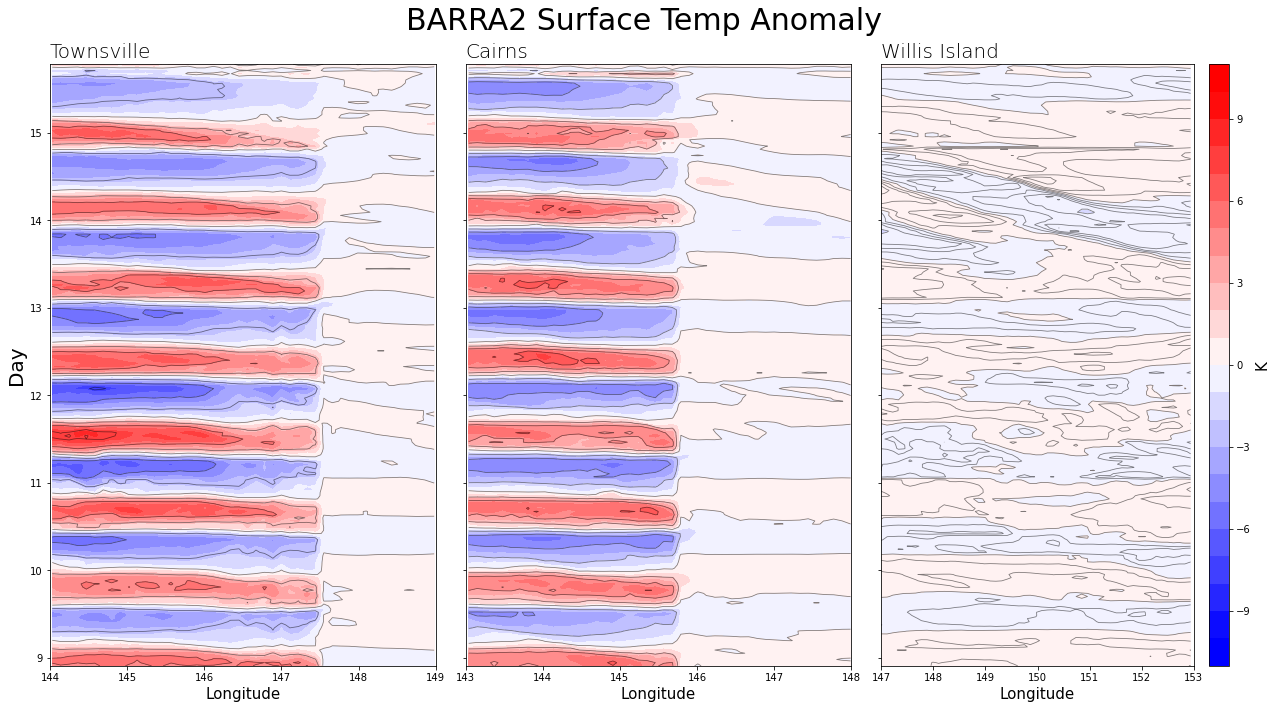

In [17]:
# make plot
fig, ax = plt.subplots(1,3,figsize=(18,10))
fig.patch.set_facecolor('white')

# Set some titles
ax[0].set_title('Townsville', loc='left', fontsize=20,fontweight=0.9)
ax[1].set_title('Cairns', loc='left', fontsize=20,fontweight=0.9)
ax[2].set_title('Willis Island', loc='left', fontsize=20,fontweight=0.9)
fig.figure.suptitle("BARRA2 Surface Temp Anomaly",fontsize=30)

# Plot of chosen variable averaged over latitude and slightly smoothed
levels = [-10,-9,-8,-7,-6,-5,-4,-3,-2,-1,0,1,2,3,4,5,6,7,8,9,10]
cf_T = ax[0].contourf(lons_T, variable_times_T, variable_data_T, levels=levels, cmap="bwr", extend='both')
cf_C = ax[1].contourf(lons_C, variable_times_C, variable_data_C, levels=levels, cmap="bwr", extend='both')
cf_W = ax[2].contourf(lons_W, variable_times_W, variable_data_W, levels=levels, cmap="bwr", extend='both')

line_colors = ['black' for l in cf_T.levels]
cs_T = ax[0].contour(lons_T, variable_times_T, variable_data_T, alpha=0.5,colors=line_colors, linewidths=0.8,linestyles='-')
cs_C = ax[1].contour(lons_C, variable_times_C, variable_data_C, alpha=0.5,colors=line_colors, linewidths=0.8,linestyles='-')
cs_W = ax[2].contour(lons_W, variable_times_W, variable_data_W, alpha=0.5,colors=line_colors, linewidths=0.8,linestyles='-')                 
                    
# cbar and cbar label                
cbar_W = plt.colorbar(cf_W, ax=ax[2],orientation='vertical', pad=0.04, aspect=30, extendrect=True)
cbar_W.set_label('K',fontsize=15)

# Make some ticks and tick labels
xticks_T = np.arange(144,150,1)
xticks_C = np.arange(143,149,1)
xticks_W = np.arange(147,154,1)            
ax[0].set_xticks(xticks_T)
ax[1].set_xticks(xticks_C)
ax[2].set_xticks(xticks_W)
                    
x_tick_labels_T = ["144","145","146","147","148","149"]
x_tick_labels_C = ["143","144","145","146","147","148"]
x_tick_labels_W = ["147","148","149","150","151","152","153"]        
ax[0].set_xticklabels(x_tick_labels_T)
ax[1].set_xticklabels(x_tick_labels_C)
ax[2].set_xticklabels(x_tick_labels_W)

y_tick_labels_T = ["8","9","10","11","12","13","14","15","16"]
ax[0].set_yticklabels(y_tick_labels_T)
ax[1].set(yticklabels=[]) 
ax[2].set(yticklabels=[]) 
                    
ax[0].set_xlabel("Longitude",fontsize=15)
ax[1].set_xlabel("Longitude",fontsize=15)
ax[2].set_xlabel("Longitude",fontsize=15)
ax[0].set_ylabel("Day",fontsize=20)            

fig.tight_layout()
plt.show()

In [ ]:
# function to read data path
def path_to_ds(date,time):
    indir = '/g/data/v46/yvh565/barra2/yhuang/'+date+time+'/' # path to where data is saved
    print('indir: ',indir)
    file = indir+'av_sfc_temp-barra_r2-hres-202202080300-202202080900.nc' # path to file
    print('file: ',file)
    return file

# Using the function: variable names are 10u and 2t
barra2_ds = xr.open_dataset(path_to_ds("20220208","T0000Z",), engine="netcdf4")